# 使用`Partition` explainer解释Pytorch预训练MobileNetV2图像分类模型



同济子豪兄 https://space.bilibili.com/1900783

代码运行云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1

2022-10-24

## 导入工具包

In [1]:
import json
import numpy as np
import torchvision
import torch
import torch.nn as nn
import shap
from PIL import Image

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入ImageNet预训练图像分类模型

In [2]:
model = torchvision.models.mobilenet_v2(pretrained=True, progress=False).eval().to(device)

## 载入ImageNet50数据集

In [3]:
X, y = shap.datasets.imagenet50()

In [4]:
X.shape

(50, 224, 224, 3)

## 载入ImageNet1000类别标注名称

下载链接：https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

In [5]:
with open('data/imagenet_class_index.json') as file:
    class_names = [v[1] for v in json.load(file).values()]

In [6]:
# class_names

## 预处理

In [7]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x 
        

transform= [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x*(1/255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

## 定义图像分类预测函数

In [8]:
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output

## 测试整个工作流正常

In [9]:
Xtr = transform(torch.Tensor(X))
out = predict(Xtr[0:3])
classes = torch.argmax(out, axis=1).detach().cpu().numpy()
print(f'Classes: {classes}: {np.array(class_names)[classes]}')

Classes: [829 132 814]: ['streetcar' 'American_egret' 'speedboat']


## 解释单张图像预测结果

In [51]:
topk = 4
batch_size = 50
n_evals = 10000

# 定义 mask，用于遮盖输入图像上的局部
masker_blur = shap.maskers.Image("blur(128,128)", Xtr[0].shape)

In [52]:
# 创建可解释分析算法
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

In [53]:
# 输入单张图像，计算shap值
idx = 1 # 图像索引号
shap_values = explainer(Xtr[idx].unsqueeze(0), max_evals=n_evals, batch_size=batch_size, outputs=shap.Explanation.argsort.flip[:topk])


  0%|          | 0/9998 [00:00<?, ?it/s]

Partition explainer: 2it [00:26, 26.16s/it]               


In [39]:
shap_values.data.shape

torch.Size([1, 224, 224, 3])

In [40]:
# 输入图像的每个像素，对于 topk 个类别的 shap 值
shap_values.values.shape

(1, 224, 224, 3, 4)

In [41]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)]

In [42]:
shap_values.data.shape

(224, 224, 3)

In [43]:
len(shap_values.values)

4

In [44]:
shap_values.values[0].shape

(224, 224, 3)

## 可视化

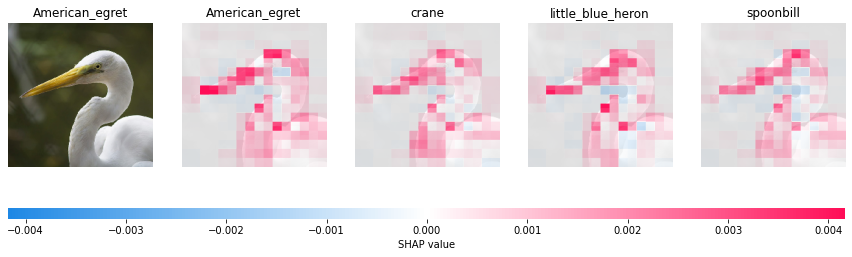

In [45]:
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names,
                true_labels=[class_names[132]])

## 解释多张图像预测结果

In [46]:
topk = 4
batch_size = 50
n_evals = 1000

# 定义 mask，用于遮盖输入图像上的局部
masker_blur = shap.maskers.Image("blur(128,128)", Xtr[0].shape)

# 创建可解释分析算法
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

# 输入多张图像
shap_values = explainer(Xtr[1:4], max_evals=n_evals, batch_size=batch_size,
                        outputs=shap.Explanation.argsort.flip[:topk])

In [47]:
# 输入图像的每个像素，对于 topk 个类别的 shap 值
shap_values.values.shape

(3, 224, 224, 3, 4)

In [48]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()
shap_values.values = [val for val in np.moveaxis(shap_values.values,-1, 0)]

In [49]:
(shap_values.data.shape, shap_values.values[0].shape)

((3, 224, 224, 3), (3, 224, 224, 3))

## 可视化

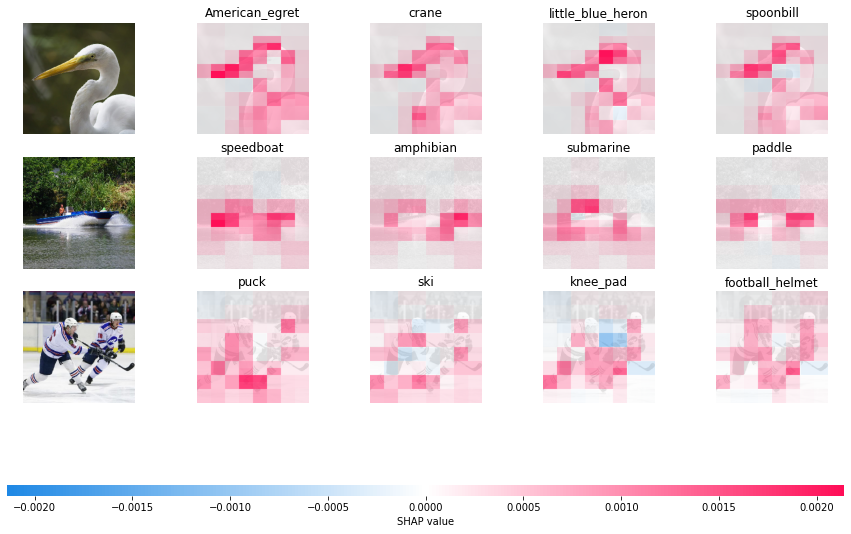

In [50]:
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)